In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns; sns.set(font_scale=1.5)
import scipy.special as sc
import scipy.optimize

c = 299792458

In [ ]:
occultations = [{'name' : '2019-02-04T08:19:11_436.4MHz', 'sel' : slice('2019-02-04T10:05', '2019-02-04T10:08'),
                    'fit_sel' : slice('2019-02-04T10:06:30', '2019-02-04T10:07:15'), 'direction' : -1,
                    'smooth' : '1s'},
               ]

In [ ]:
def plot_occultation(occ):
    power = xr.open_dataset("2019-02-04T08_19_11_436.4MHz_power.nc")
    plt.figure(figsize=(14,8),facecolor='w')
    sel = occ['sel']
    power['power_direct'].sel(time = sel).plot()
    plt.title(f'DSLWP-B lunar occultation {sel.start} - {sel.stop}')
    plt.xlabel('UTC time')
    plt.ylabel('Power (linear scale)')

In [ ]:
for occultation in occultations:
    plot_occultation(occultation)

In [ ]:
def fit_occultation(occ):
    power = xr.open_dataset("2019-02-04T08_19_11_436.4MHz_power.nc")
    data = power['power_direct'].sel(time = occ['fit_sel'])
    try:
        data_res = data.resample(time = occ['smooth']).mean()
        data_original = data
        data = data_res
    except KeyError:
        data_original = data
    
    t = data.coords['time']
    s = (t - t[t.size//2]).values.astype('float') * 1e-9
    t_original = data_original.coords['time']
    s_original = (t_original - t_original[t_original.size//2]).values.astype('float') * 1e-9
    
    cut = np.mean(data)
    offset = int(np.argmin(np.abs(data-cut)).values)
    first_max = offset
    d = occ['direction']
    while data[first_max] <= data[first_max+d]:
        first_max += d
    first_min = first_max
    while data[first_min] >= data[first_min+d]:
        first_min += d
    space_hint = s[first_min]-s[first_max]
    
    p0 = (s[offset], data[first_min:].mean().values, 0.5/space_hint * occ.get('vel_hint_correction', 1))
    try:
        popt, pcov = scipy.optimize.curve_fit(diffraction, s_original, data_original, p0 = p0)
        optimization_succeeded = True
        occ['fit_t0'] = t[t.size//2].values + popt[0] * 1e9 * np.timedelta64(1, 'ns')
        occ['fit_v'] = popt[2]
    except RuntimeError:
        optimization_succeeded = False
    
    plt.figure(figsize = (14,8), facecolor='w')
    (1/popt[1]*data_original).plot()
    if optimization_succeeded:
        plt.plot(t_original, 1/popt[1]*diffraction(s_original, *popt))
    
    plt.title(f"Diffraction fit {occ['sel'].start} - {occ['sel'].stop}")
    plt.xlabel('UTC time')
    plt.ylabel('Relative power (linear scale)')
    plt.legend(['Measurements', 'Model fit'])

In [ ]:
for occ in occultations:
    fit_occultation(occ)

In [ ]:
def compute_occultation_from_gmat(occ):
    gmat = xr.open_dataset("2019-02-04T08_19_11_436.4MHz_gmat.nc")
    a = gmat['gmat'].sel(object = 'dslwpb_lunafixed_x')
    b = gmat['gmat'].sel(object = 'gs_lunafixed_x')
    d = b - a
    u = d/np.sqrt((d**2).sum('xyz'))
    A = np.abs((a*u).sum('xyz'))
    B = np.abs((b*u).sum('xyz'))
    H = np.sqrt((a**2).sum('xyz') - A**2)
    R = 1737.1 # lunar radius
    x = H - R
    delta = np.sqrt(A**2 + x**2) + np.sqrt(B**2 + x**2) - A - B
    lbd = c / 436.4e6
    nu = 2*np.sqrt(1e3*delta/lbd)*np.sign(x)
    dnu = nu.differentiate('time', datetime_unit='s')
    search_t0 = slice(occ['fit_t0'] + np.timedelta64(-300,'s'), occ['fit_t0'] + np.timedelta64(300,'s'))
    occ['gmat_t0'] = gmat.coords['time'].sel(time = search_t0)[np.abs(nu.sel(time = search_t0)).argmin()].values
    occ['gmat_v'] = float(dnu.interp(time = occ['fit_t0']).values)

In [ ]:
for occultation in occultations:
    compute_occultation_from_gmat(occultation)

In [ ]:
[1-o['fit_v']/o['gmat_v'] for o in occultations]

In [ ]:
[(o['fit_t0']-o['gmat_t0']).astype('float')*1e-9 for o in occultations]

In [ ]:
plt.figure(figsize = (14,8), facecolor='w')
nu = np.linspace(-5,5,10000)
plt.plot(nu, diffraction(nu, 0, 1, 1))
plt.plot(nu, diffraction(nu, 0, 1, 0.5))
plt.legend(['$v = 1$','$v = 0.5$'])
plt.xticks(np.arange(-5,6));

In [ ]:
[print(str(o['fit_v'])) for o in occultations]
[print(str(o['fit_t0'])) for o in occultations]

In [ ]:
test = xr.open_dataset("2019-02-04T08_19_11_436.4MHz_power.nc")

In [ ]:
test

---

In [2]:
def diffract(t, A):
#     θ = t-t0
#     cc, ss = scipy.special.fresnel(v*θ)
    cc, ss = scipy.special.fresnel(t)
    x = A*0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
    return x

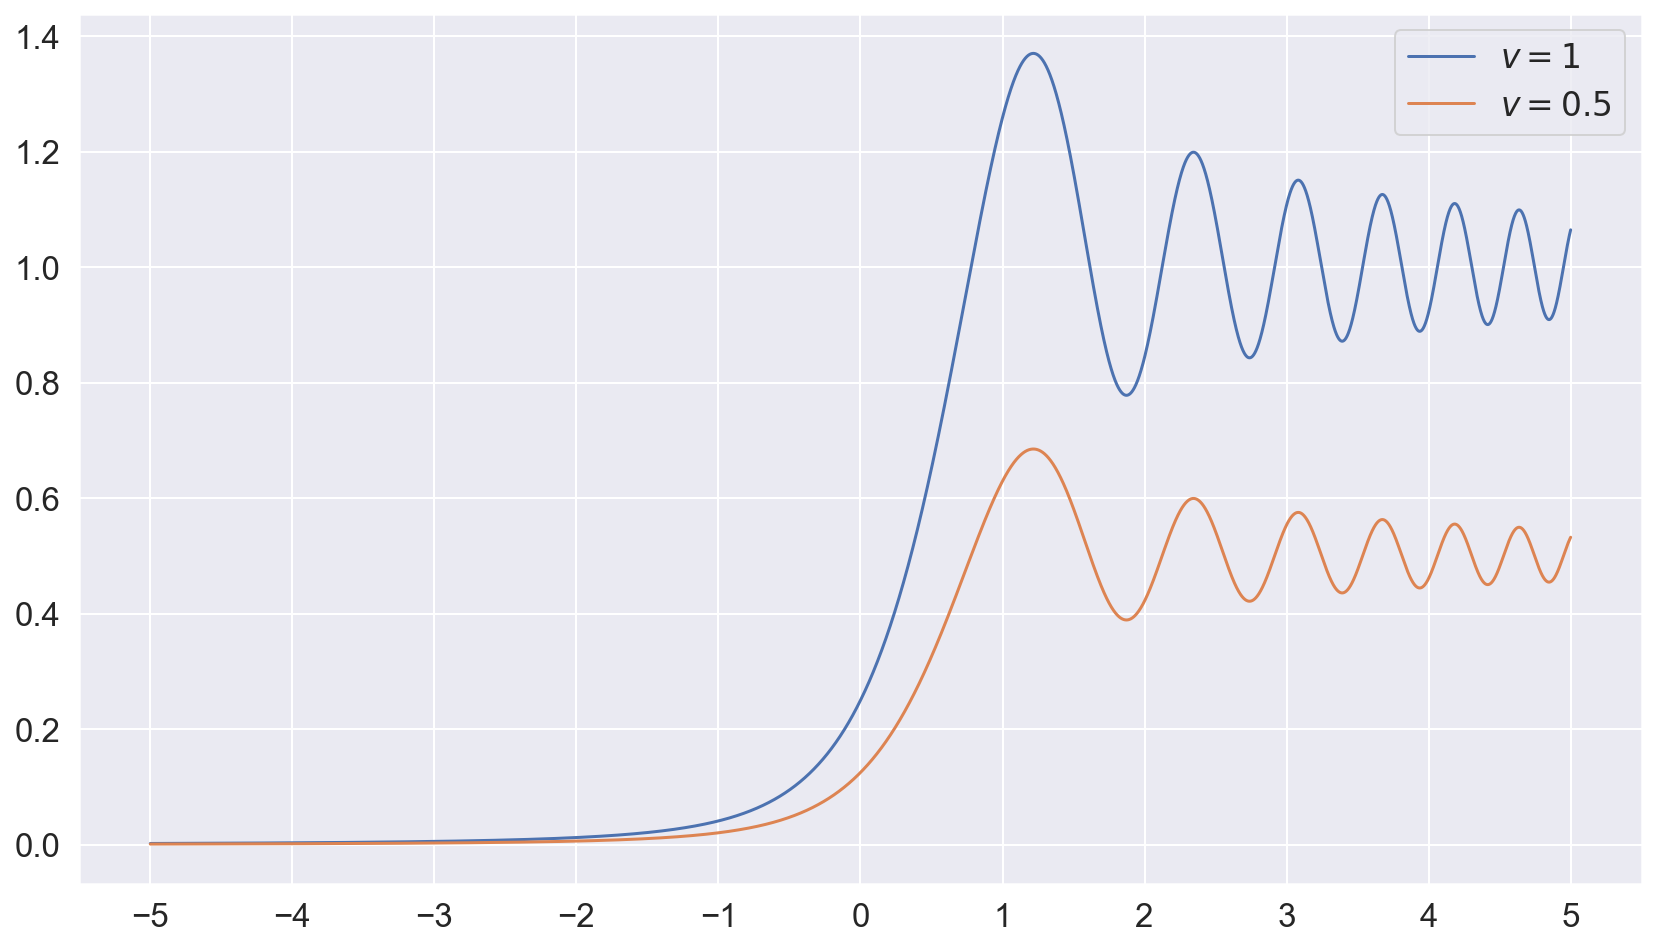

In [3]:
plt.figure(figsize = (14,8), facecolor='w')
nu = np.linspace(-5,5,10000)
plt.plot(nu, diffract(nu, 1))
plt.plot(nu, diffract(nu, 0.5))
plt.legend(['$v = 1$','$v = 0.5$'])
plt.xticks(np.arange(-5,6));

In [4]:
# artificial data dengan derau
x_data = np.linspace(-5,5,100)
sigma_noise = 5
amplitude = 100
y_data = diffract(x_data, amplitude)
y_data = np.random.normal(y_data, scale=sigma_noise)

In [5]:
x_data

array([-5.        , -4.8989899 , -4.7979798 , -4.6969697 , -4.5959596 ,
       -4.49494949, -4.39393939, -4.29292929, -4.19191919, -4.09090909,
       -3.98989899, -3.88888889, -3.78787879, -3.68686869, -3.58585859,
       -3.48484848, -3.38383838, -3.28282828, -3.18181818, -3.08080808,
       -2.97979798, -2.87878788, -2.77777778, -2.67676768, -2.57575758,
       -2.47474747, -2.37373737, -2.27272727, -2.17171717, -2.07070707,
       -1.96969697, -1.86868687, -1.76767677, -1.66666667, -1.56565657,
       -1.46464646, -1.36363636, -1.26262626, -1.16161616, -1.06060606,
       -0.95959596, -0.85858586, -0.75757576, -0.65656566, -0.55555556,
       -0.45454545, -0.35353535, -0.25252525, -0.15151515, -0.05050505,
        0.05050505,  0.15151515,  0.25252525,  0.35353535,  0.45454545,
        0.55555556,  0.65656566,  0.75757576,  0.85858586,  0.95959596,
        1.06060606,  1.16161616,  1.26262626,  1.36363636,  1.46464646,
        1.56565657,  1.66666667,  1.76767677,  1.86868687,  1.96

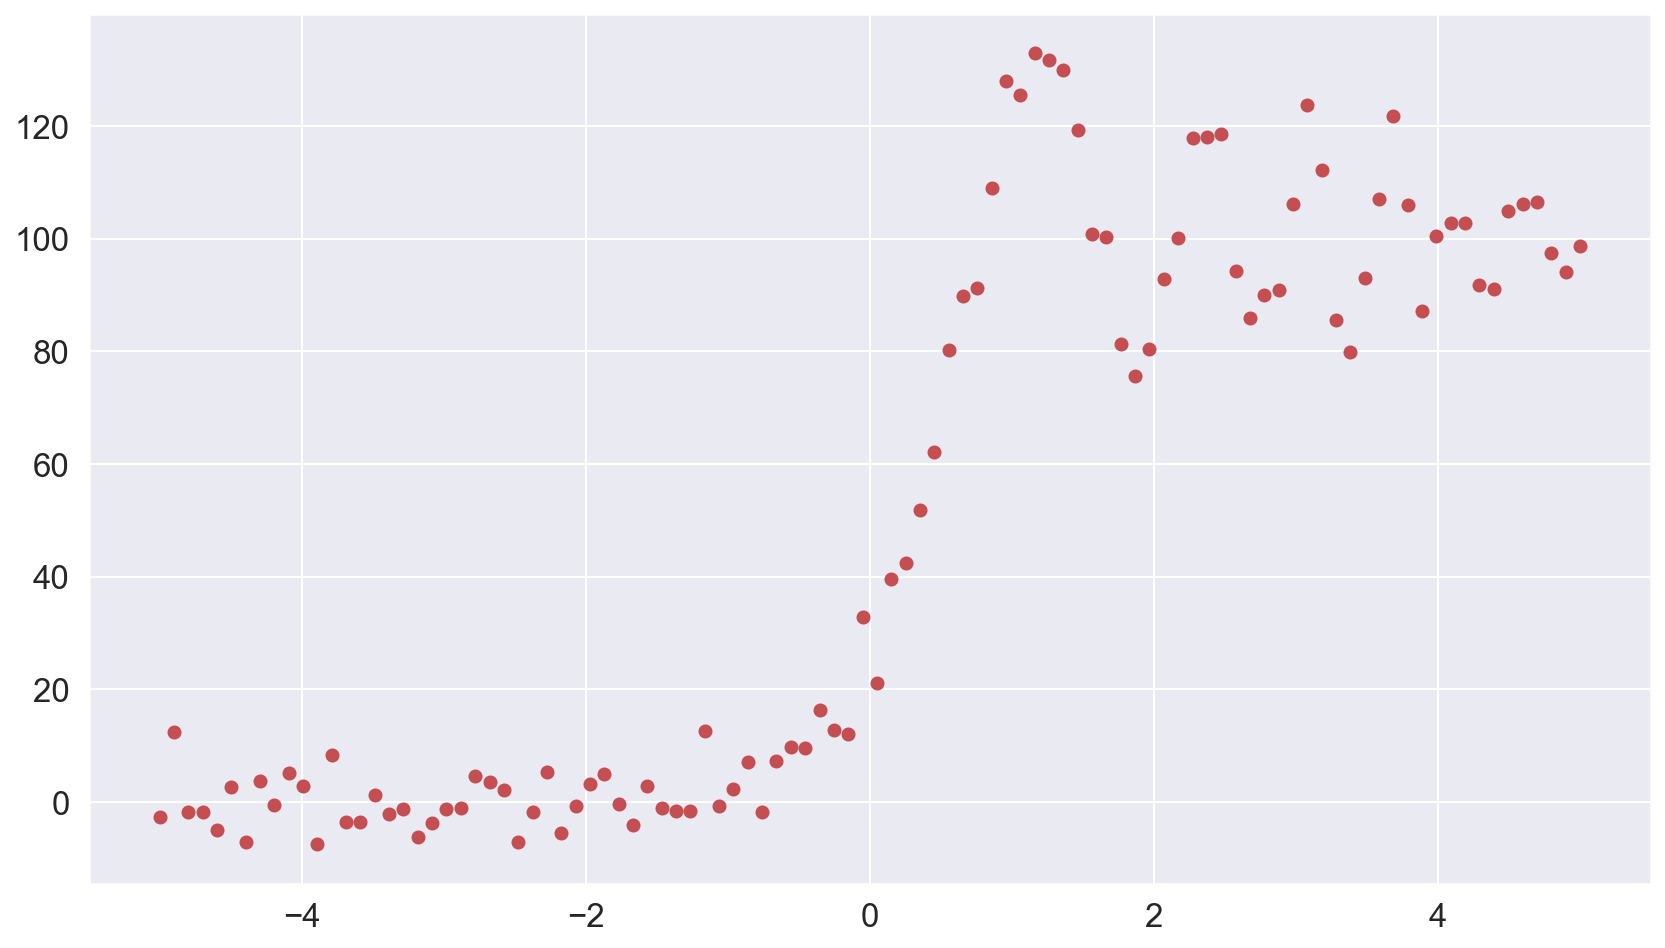

In [6]:
plt.figure(figsize = (14,8), facecolor='w')
# nu = np.linspace(-5,5,10000)
# plt.plot(nu, diffract(nu, 0, 100, 1))
plt.scatter(x_data, y_data, c='r')

In [7]:
import pandas as pd

data = pd.DataFrame({"x":x_data, "y":y_data}, dtype=float)
data['x'].dtypes

dtype('float64')

In [8]:
import pymc3 as pm
import arviz as az

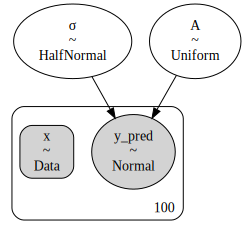

In [9]:
coords = {"observation": data.index.values}
# v = np.random.rand(100)

with pm.Model(coords=coords) as model_fresnel:
    x = pm.Data("x", data["x"], dims="observation")
    
#     x0 = pm.Normal("x0", mu=0., sigma=10.)
#     v = pm.Normal("v", mu=1., sigma=10.)
#     v = 1.

#     C, S = scipy.special.fresnel(v*(x-x0))
#     priors
    amp = pm.Uniform('A', 0., 500)
    σ = pm.HalfNormal('σ', sigma=5)
#     model
    mu = diffract(x_data, amp) # model-nya (expected value)
#     likelihood
    y_pred = pm.Normal('y_pred', mu=mu, sd=σ, observed=data["y"], dims="observation") # likelihood-nya

pm.model_to_graphviz(model_fresnel)

In [ ]:
# v

In [10]:
with model_fresnel:
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, A]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 90 seconds.


In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,99.625,0.717,98.259,100.992,0.009,0.006,6970.0,5108.0,1.0
σ,5.030,0.368,4.344,5.714,0.004,0.003,6930.0,5623.0,1.0


In [12]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

Text(0, 0.5, '$\\sigma$')

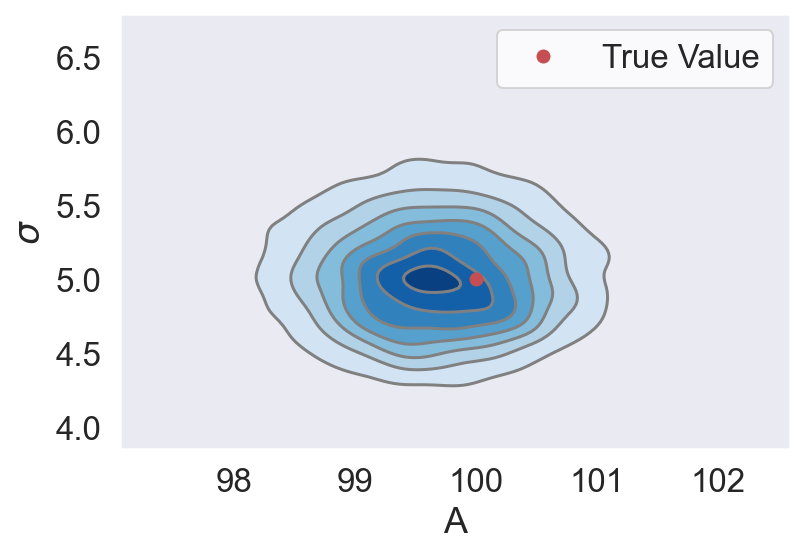

In [16]:
# fig, ax = plt.subplots()
az.plot_kde(
    trace.posterior.stack(sample=("chain", "draw")).A.values,
    trace.posterior.stack(sample=("chain", "draw")).σ.values,
    contourf_kwargs={"cmap": "Blues"},
)
plt.plot(amplitude, sigma_noise, "ro", label="True Value")
plt.legend(facecolor="white", frameon=True);
plt.xlabel("A")
plt.ylabel("$\sigma$")

In [17]:
az.plot_hdi(
    x_data,
    trace.posterior.A,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
#     ax=ax[0],
#     color="C1",
)

C:\Anaconda3\envs\work2\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


TypeError: Dimension mismatch for x: (100,) and hdi: (2000, 2). Check the dimensions of y andhdi_kwargs to make sure they are compatible

In [18]:
chain_count =  trace.posterior.stack(sample=("chain","draw")).A.values.shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_fresnel)
# data_spp = az.from_pymc3(trace=trace, posterior_predictive=y_pred_g)

In [19]:
# joint_plt = az.plot_joint(data_spp, var_names=['A', 'σ'], kind='kde', fill_last=False);
# joint_plt[0].set_xlabel(r'$A$', fontsize=18);
# joint_plt[1].set_title(r'$A$', fontsize=18);
# joint_plt[0].set_ylabel(r'$\sigma$', fontsize=18);

joint_plt = az.plot_pair(data_spp, var_names=['A', 'σ'], kind='kde', fill_last=False);

NameError: name 'data_spp' is not defined

array([<AxesSubplot:title={'center':'A'}>,
       <AxesSubplot:title={'center':'σ'}>], dtype=object)

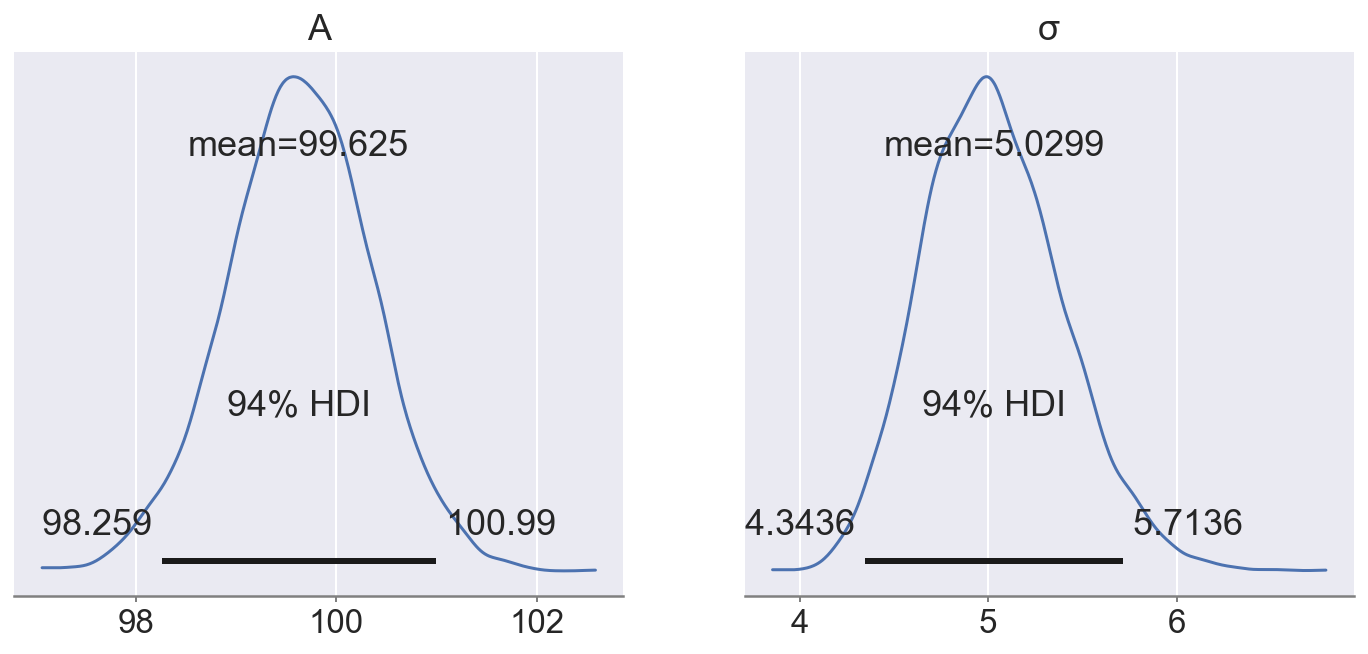

In [20]:
pm.plot_posterior(trace, var_names=None, round_to=5, figsize = (12,5))

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

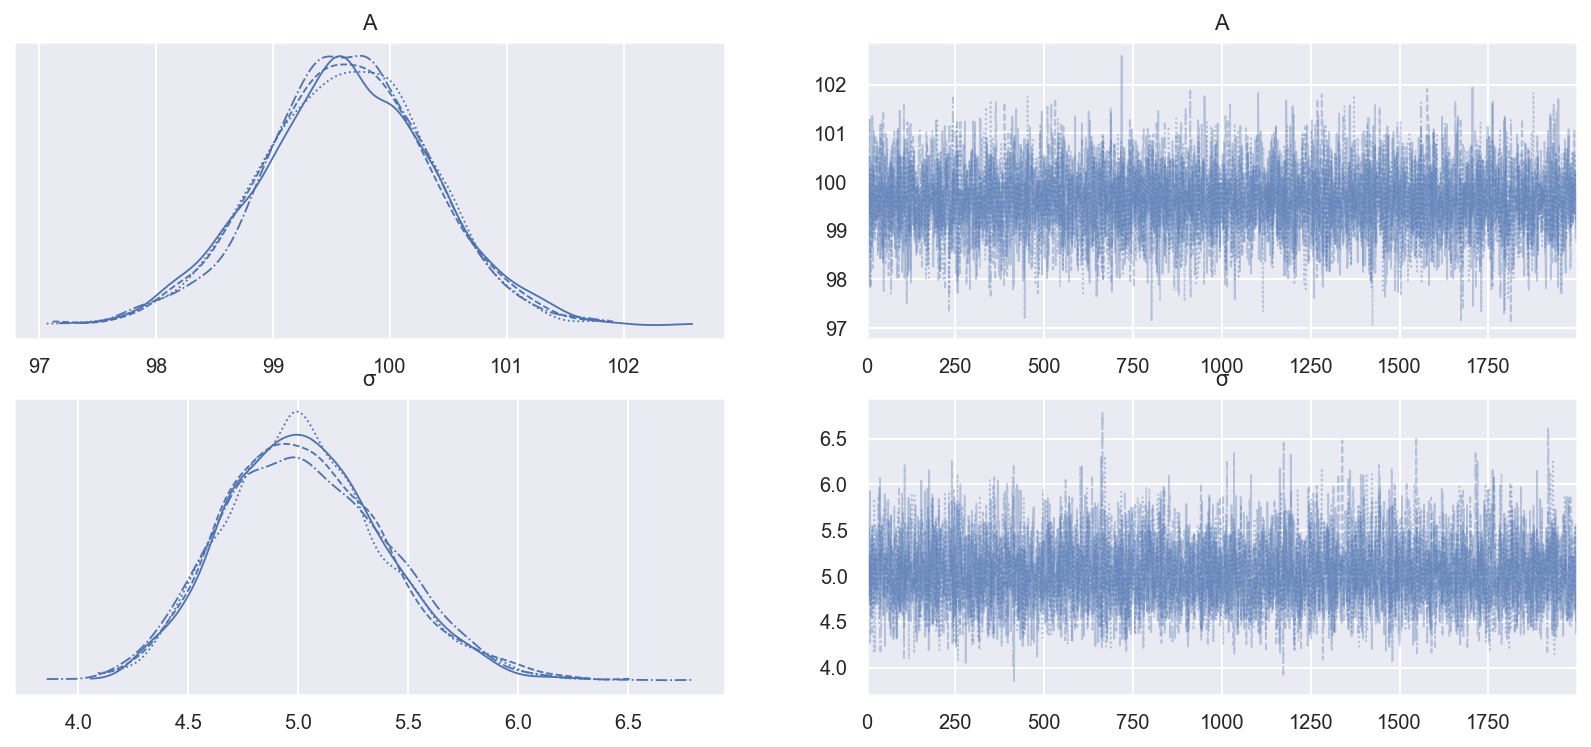

In [21]:
az.plot_trace(trace, figsize=(14,6))

In [22]:
crit_l = np.percentile(y_pred_g['y_pred'], 2.5, axis=0)  # ambil 2.5% 
crit_u = np.percentile(y_pred_g['y_pred'], 97.5, axis=0)  # ambil 97.5%
mean_spp = np.mean(y_pred_g['y_pred'], axis=0) # Median

# crit_l = pm.stats()['y_pred']['quantiles'][2.5]

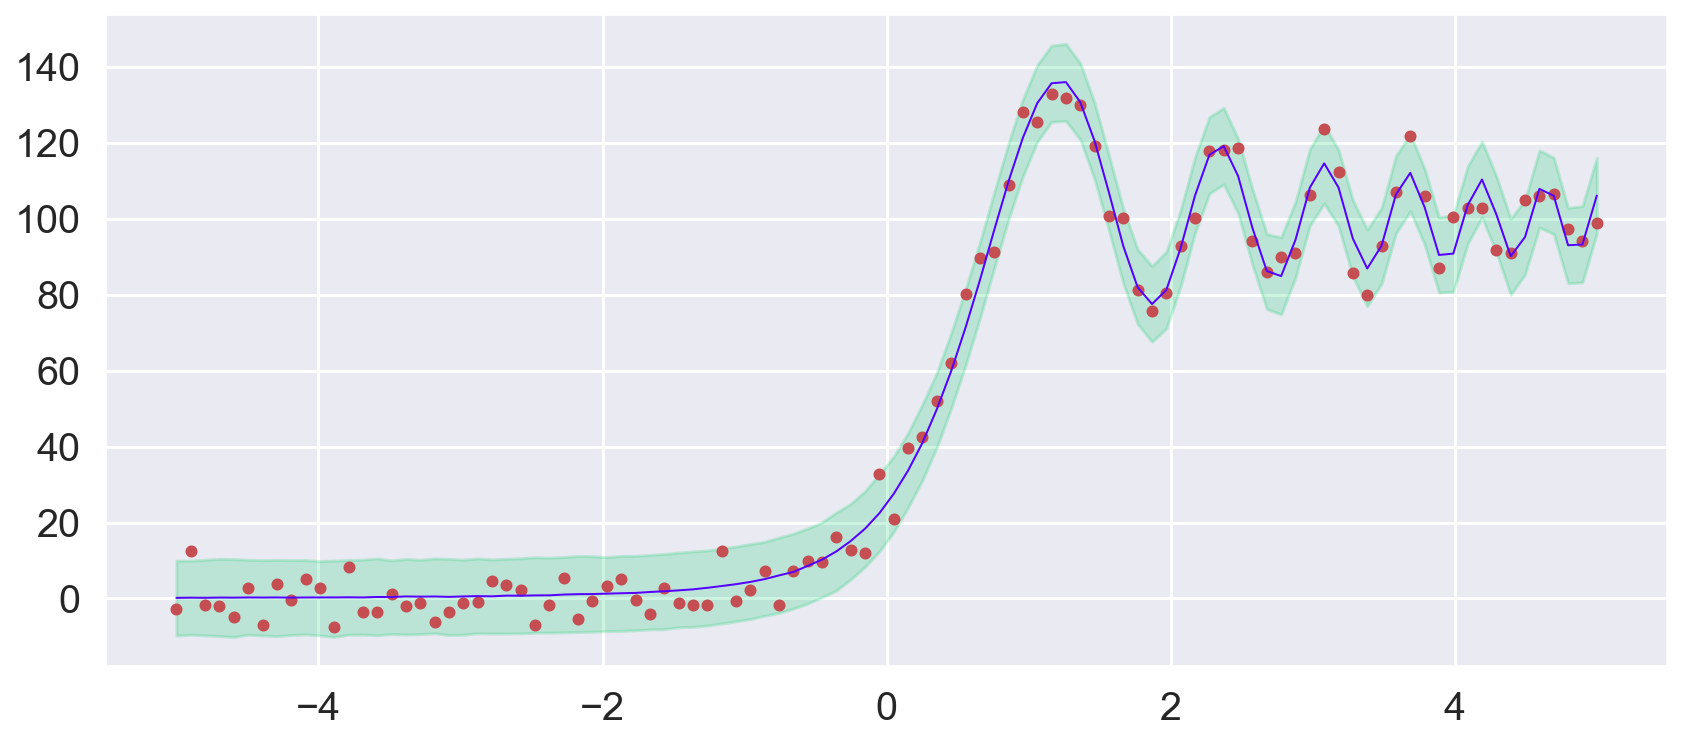

In [23]:
import seaborn as sns

with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(14,6 ))

#     plt.plot(nu, diffract(nu, 0, 100, 1))
#     plt.plot(nu, diffract(nu, 0, np.mean(trace['A']), 1), 'k-', alpha=0.3, linewidth=1)
    plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
    plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
    plt.scatter(x_data, y_data, c='r', marker='.')

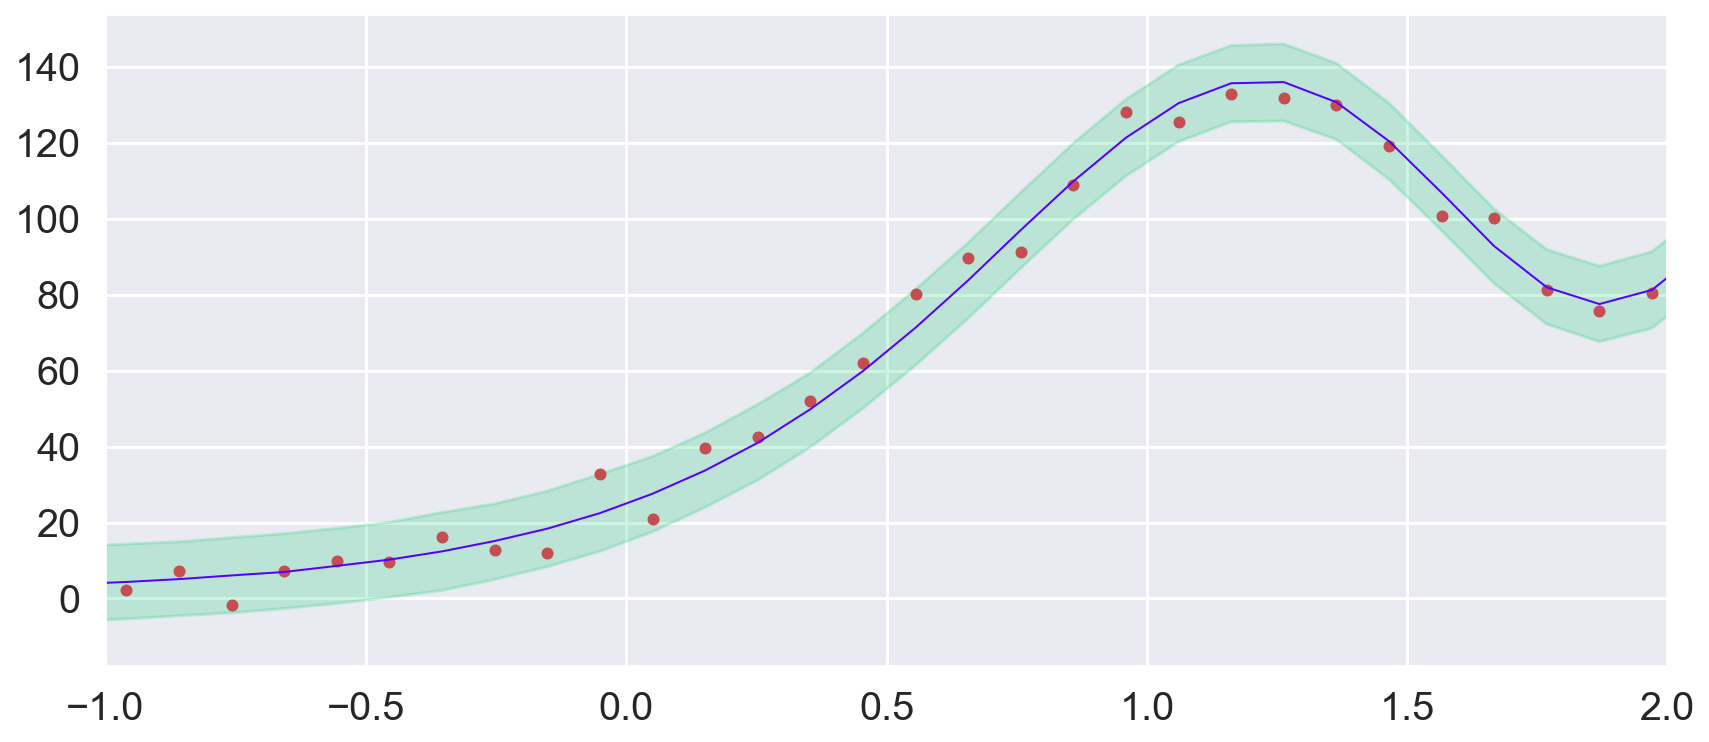

In [24]:
with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(14,6 ))

#     plt.plot(nu, diffract(nu, 0, np.mean(trace['A']), 1), 'k-', alpha=0.3, linewidth=1)
    plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
    plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
    plt.scatter(x_data, y_data, c='r', marker='.')
    plt.xlim(-1, 2)

### Percobaan membuat fungsi Fresnel dengan multi-variabel bebas

In [25]:
def fresnel_number(x, λ, d):
#     Fresnel number tidak berdimensi
#     λ = 15000 #satuan Angstrom
#     D = 4e18 #satuan Angstrom
    return x*1e10*np.sqrt(2/(λ*d)) # x dalam satuan meter

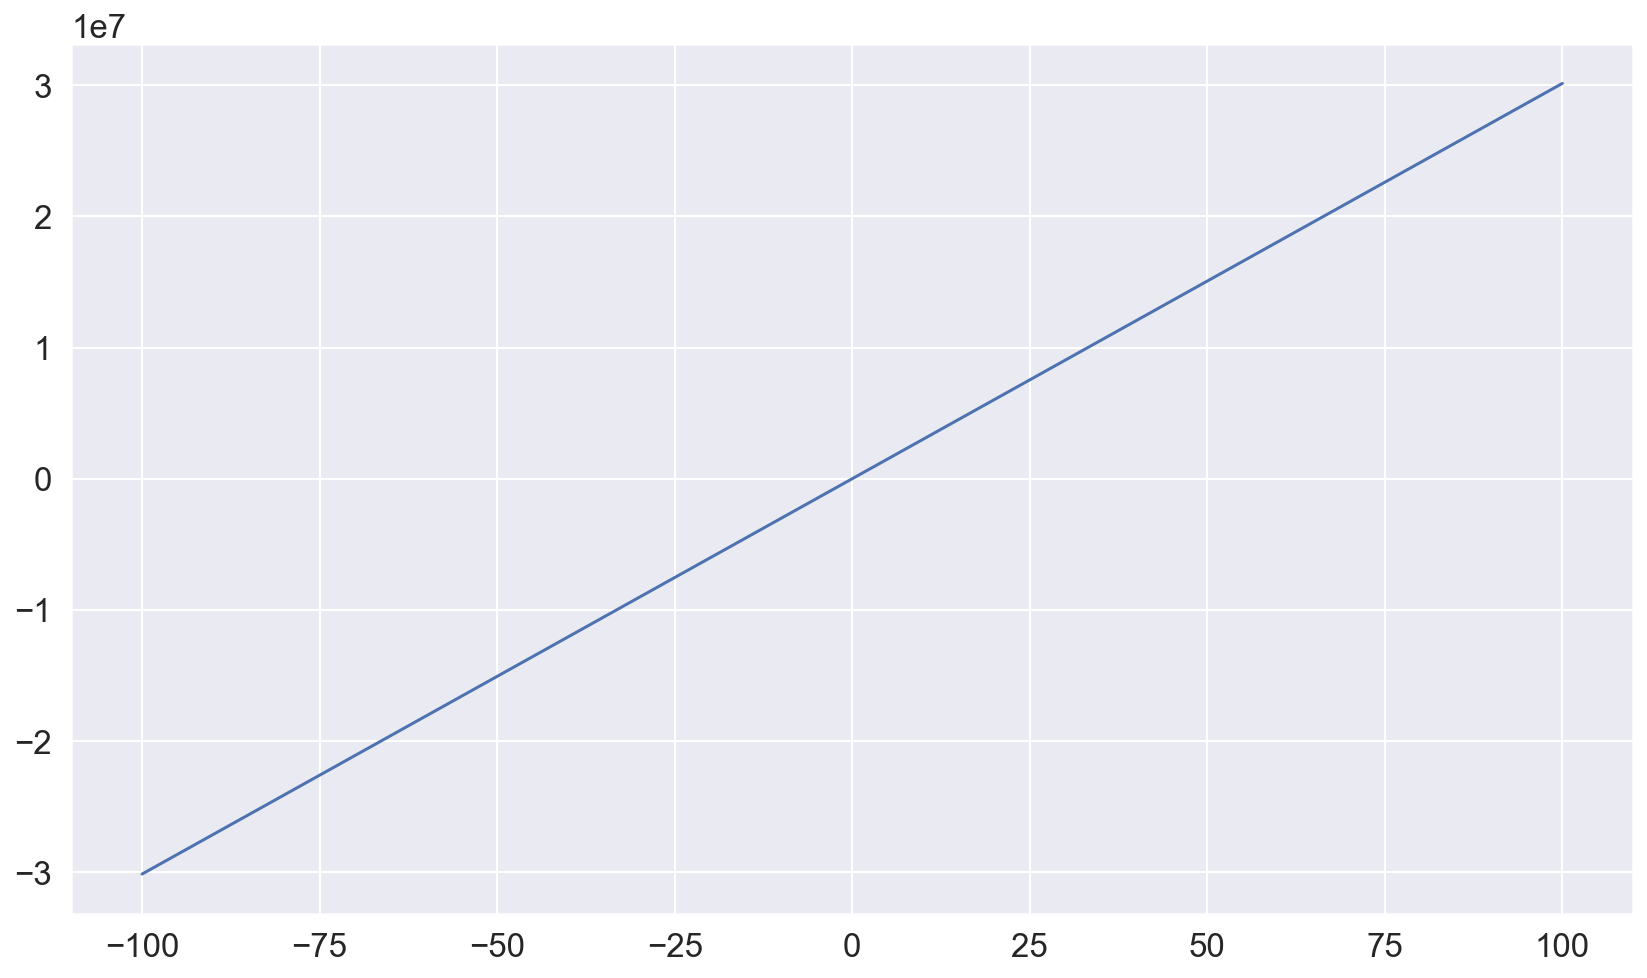

In [26]:
xaxis = np.linspace(-100,100,10000)

plt.figure(figsize = (14,8), facecolor='w')
plt.plot(xaxis, fresnel_number(xaxis, 5500, 4e5))

In [27]:
xaxis = np.linspace(-5,5,10000)

def difraksi(x, w, A):
#     w = x*1e10*np.sqrt(2/(λ*d)) # x dalam satuan meter
#     co, si = scipy.special.fresnel(w / np.sqrt(np.pi/2))
    co, si = scipy.special.fresnel(w)
    yy = A*0.5*((co + 0.5)**2 + (si + 0.5)**2)
    return yy

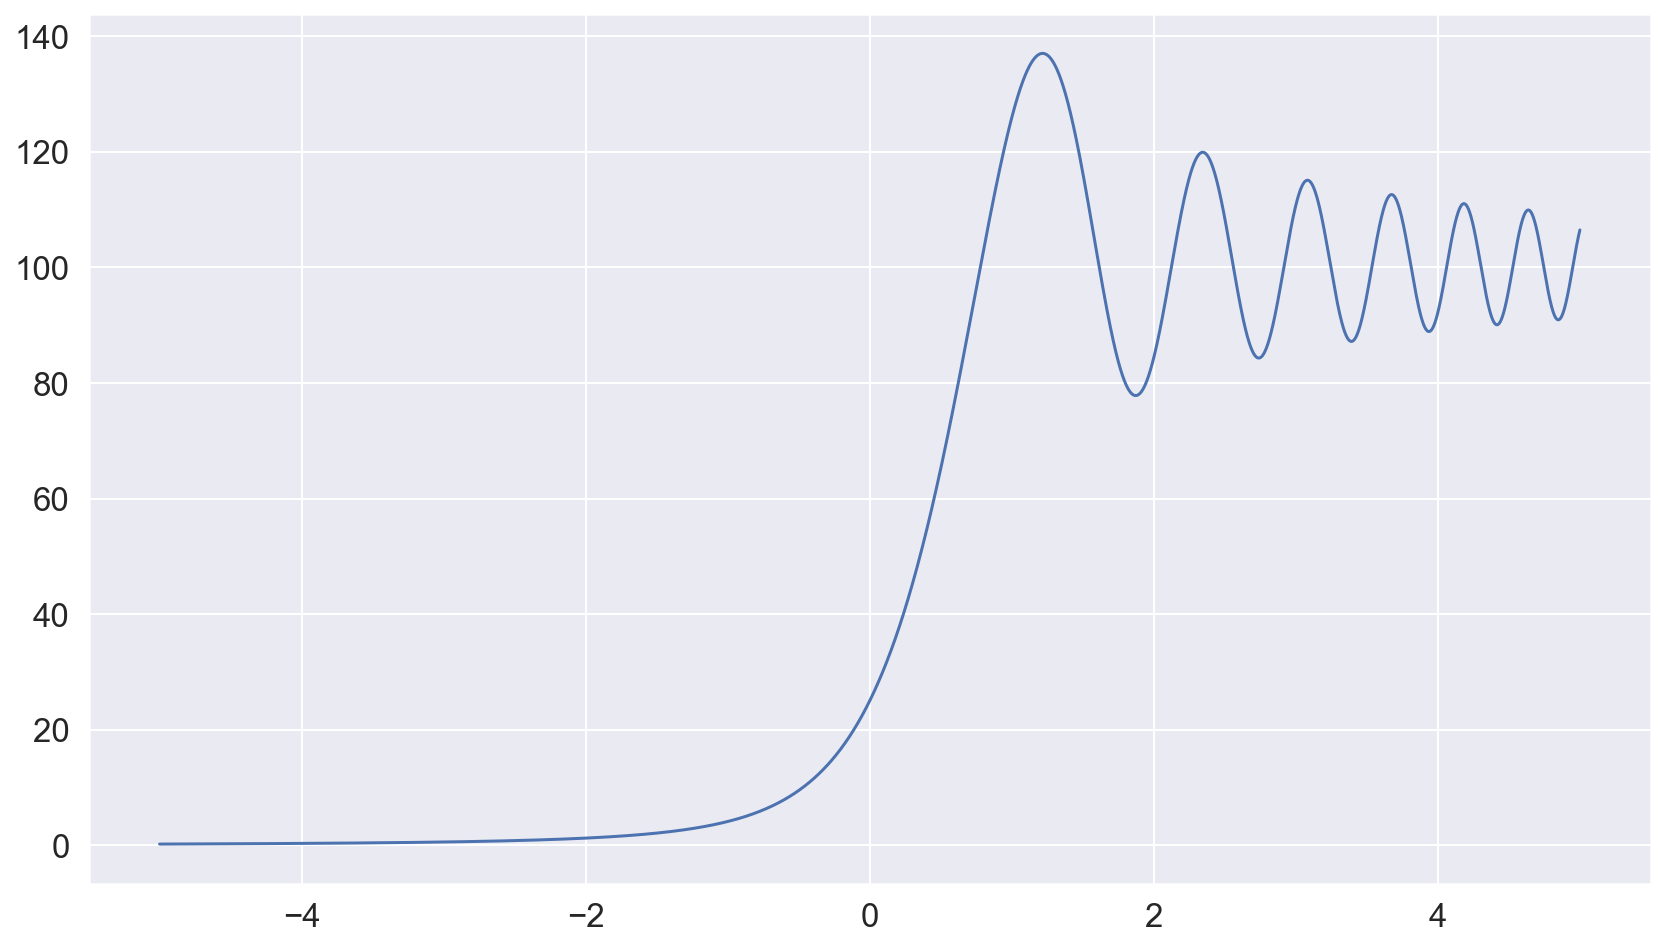

In [28]:
plt.figure(figsize = (14,8), facecolor='w')
plt.plot(xaxis, difraksi(xaxis, xaxis, 100))

In [29]:
# simulated data with noise
xx = np.linspace(-5, 5, 200)
σ2 = 10

yy = difraksi(xx, xx, 100)
yy = np.random.normal(yy, scale=σ2)

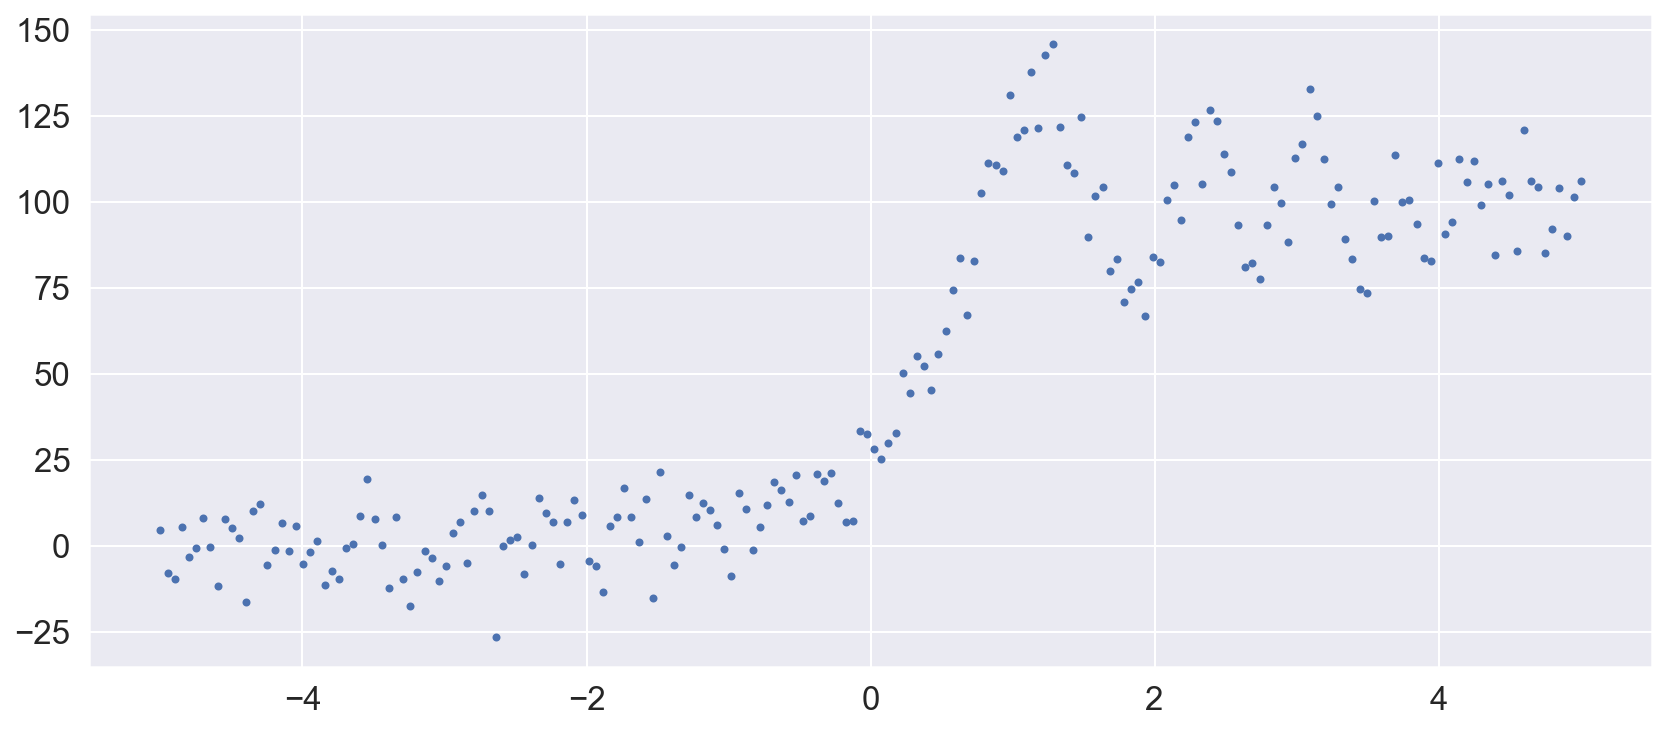

In [30]:
plt.figure(figsize=(14,6))
plt.scatter(xx, yy, marker='.')

In [31]:
import pandas as pd

data = pd.DataFrame({"x": xx, "y": yy})

In [32]:
coords = {"observation": data.index.values}

In [33]:
data.head()

,x,y
0,-5.000000,4.762601
1,-4.949749,-7.818874
2,-4.899497,-9.594124
3,-4.849246,5.387071
4,-4.798995,-3.287783


In [34]:
with pm.Model(coords=coords) as model2:
    x = pm.Data('x', data['x'], dims='observation')
    λ = pm.Normal('λ', 9000, sigma=100)
    d = pm.Normal('d', 3e18, sigma=100)
#     ww = fresnel_number(xx, λ, d)
    w = fresnel_number(x, λ, d)
#     w_baru = pm.Normal('w_baru', mu=w, sigma=10, dims="observation")
    
    A = pm.Normal('A', mu=50, sigma=100)
    
    ϵ = pm.HalfCauchy('ϵ', beta=1.)

#     cc, ss = scipy.special.fresnel(w / np.sqrt(np.pi/2))
    
    μ = difraksi(x, w, A)
#     μ = np.sin(w)
    μ_pred = pm.Normal('μ_pred', mu=μ, sd=ϵ, observed=data['y'], dims="observation")
    
pm.model_to_graphviz(model2)  

TypeError: ufunc 'fresnel' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# x2 = np.linspace(-5,5,200)

# with pm.Model() as tes_model:
#     d = pm.Normal('d', 3, 10)
#     err = pm.HalfCauchy('err', beta=1)
    
#     p = (x2/2) + d
    
#     ν = np.sin(p)
    
#     pred = pm.Normal('pred', mu=ν, sigma=err, observed=yy)
    
# pm.model_to_graphviz(tes_model) 

In [ ]:
with model2:
    trace = pm.sample(1000, tune=500, return_inferencedata=True)

In [ ]:
az.plot_trace(trace)

In [ ]:
with model2:
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

In [ ]:
az.summary(trace)

In [ ]:
chain_count =  trace.posterior.stack(sample=("chain", "draw")).A.values.shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model2)
# data_spp = az.from_pymc3(trace=trace, posterior_predictive=y_pred_g)

In [ ]:
joint_plt = az.plot_pair(data_spp, var_names=['I', 'ϵ'], kind='kde', fill_last=False);

In [ ]:
crit_l = np.percentile(y_pred_g['μ_pred'], 2.5, axis=0)  # 2.5% persentil 
crit_u = np.percentile(y_pred_g['μ_pred'], 97.5, axis=0)  # 97.5% persentil
mean_spp = np.mean(y_pred_g['μ_pred'], axis=0) # Median

In [ ]:
with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(14,6 ))

    plt.plot(xx, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
    plt.fill_between(xx, crit_l, crit_u, alpha=0.2, color="#00cc66")
    plt.scatter(xx, yy, c='r', marker='.')
#     plt.xlabel(r'$t$')
    plt.ylabel('Intensity')
    plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

In [36]:
import pandas as pd

In [37]:
df = pd.read_csv("jabbah-20211221-dualaperture.csv", sep=',')

In [38]:
df

,FrameNum,timeInfo,signal-Jabbah,signal-ref,appsum-Jabbah,avgbkg-Jabbah,stdbkg-Jabbah,nmaskpx-Jabbah,maxpx-Jabbah,xcentroid-Jabbah,ycentroid-Jabbah,appsum-ref,avgbkg-ref,stdbkg-ref,nmaskpx-ref,maxpx-ref,xcentroid-ref,ycentroid-ref
0,4400.0,[17:17:58.7247828],2874.0,46.0,4719.0,32.95,4.60,56,255,314.34,354.45,658.0,16.55,3.16,-37,31,526.00,65.00
1,4401.0,[17:17:58.7328392],2845.0,45.0,4699.0,33.11,4.68,56,255,314.50,354.29,652.0,16.41,3.20,-37,33,526.00,65.00
2,4402.0,[17:17:58.7408955],2274.0,20.0,3992.0,33.04,4.66,52,255,314.31,354.60,636.0,16.65,3.15,-37,35,526.00,65.00
3,4403.0,[17:17:58.7489519],2336.0,83.0,3886.0,32.98,4.54,47,255,314.04,354.81,692.0,16.47,3.27,-37,32,526.00,65.00
4,4404.0,[17:17:58.7570083],2162.0,202.0,3637.0,32.79,4.59,45,255,313.87,354.71,398.0,16.29,3.23,12,55,529.50,65.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,4796.0,[17:18:02.0122690],-12.0,84.0,1193.0,32.56,4.55,-37,52,318.00,355.00,698.0,16.58,3.24,-37,39,530.00,66.00
397,4797.0,[17:18:02.0203254],-12.0,86.0,1190.0,32.50,4.47,-37,48,318.00,355.00,695.0,16.45,3.24,-37,36,530.00,66.00
398,4798.0,[17:18:02.0283818],22.0,204.0,1228.0,32.59,4.45,-37,48,317.00,356.00,418.0,16.48,3.26,13,58,529.15,66.54
399,4799.0,[17:18:02.0364382],32.0,486.0,1234.0,32.49,4.43,-37,50,317.00,355.00,881.0,16.47,3.24,24,79,529.29,66.00


In [39]:
sumbu_x = df['FrameNum']
sumbu_y = df['signal-Jabbah']

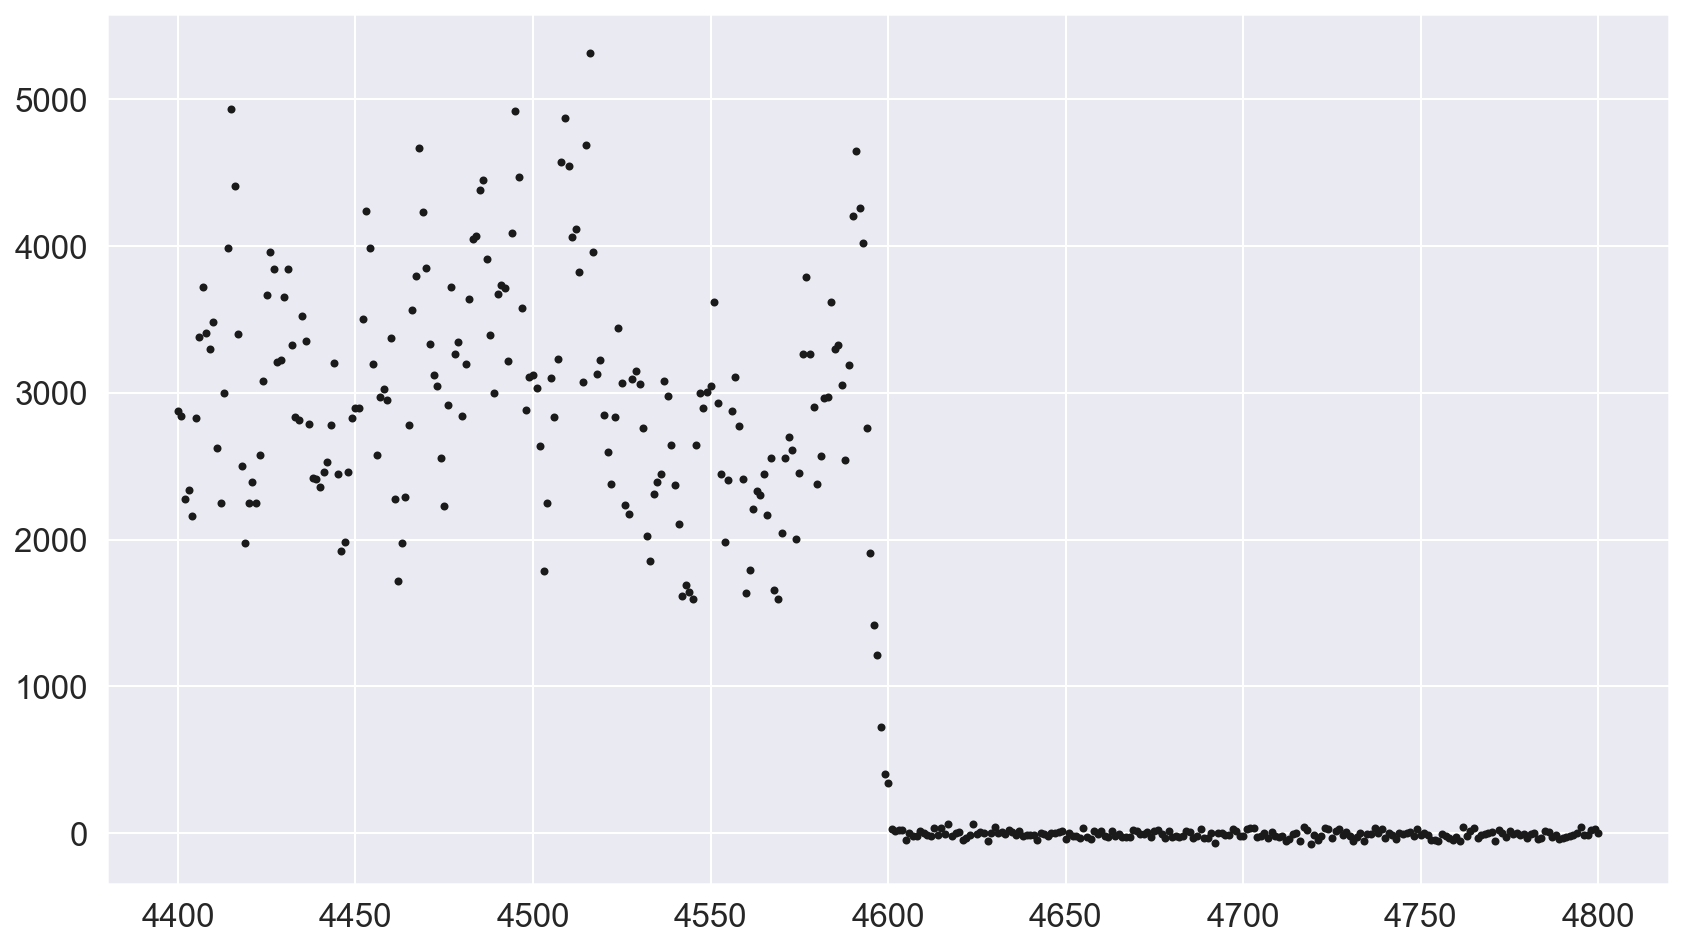

In [40]:
plt.figure(figsize=(14,8))
plt.scatter(sumbu_x, sumbu_y, marker='.', c='k')

## Normalisasi intensitas

In [41]:
# l1, l2 = 4450, 4550

In [42]:
df_new = df[['FrameNum','signal-Jabbah']]
df_new.columns = ['Frame', 'Signal']

In [43]:
signal_mean = df_new.loc[:150,:]['Signal'].mean()

In [44]:
y_axis = df_new['Signal'] / signal_mean

Text(0.5, 0, 'Frame')

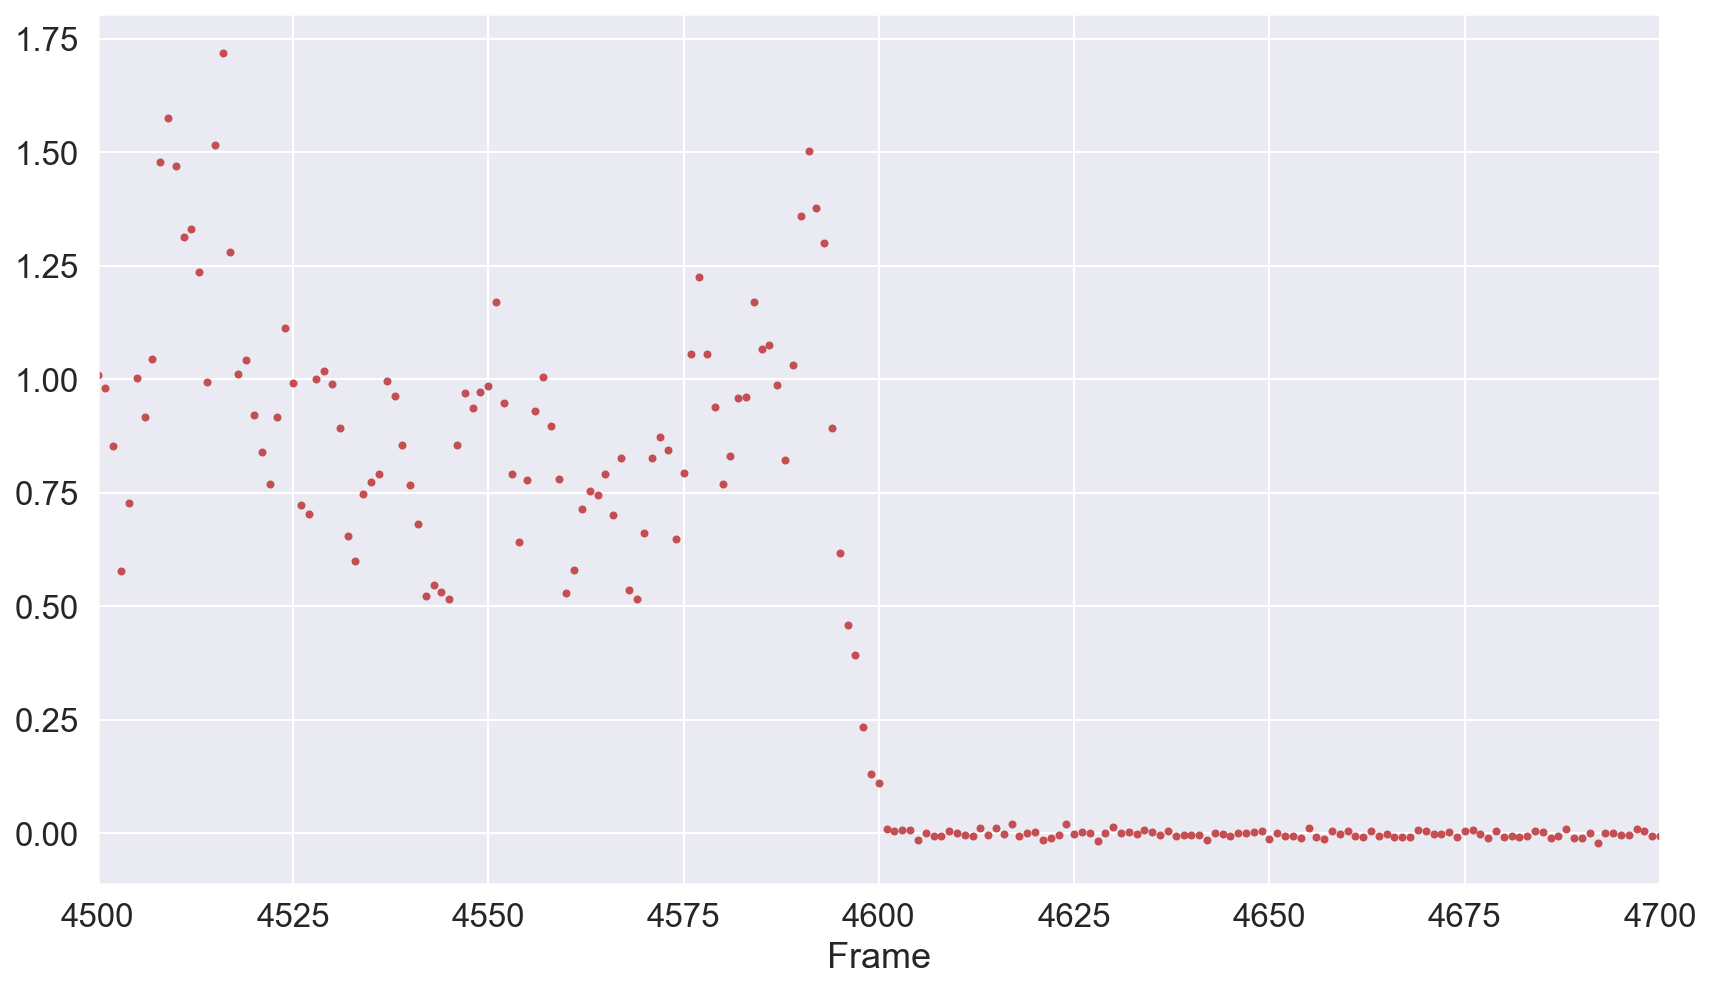

In [45]:
plt.figure(figsize=(14,8))
plt.plot(sumbu_x, y_axis, 'r.')
plt.xlim(4500, 4700)
plt.xlabel('Frame')

In [47]:
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']'))) # hilangkan karakter [ dan ] dari data

In [48]:
df['timeInfo'] = pd.to_datetime(df['timeInfo']) # ubah ke format waktu

In [49]:
df

,FrameNum,timeInfo,signal-Jabbah,signal-ref,appsum-Jabbah,avgbkg-Jabbah,stdbkg-Jabbah,nmaskpx-Jabbah,maxpx-Jabbah,xcentroid-Jabbah,ycentroid-Jabbah,appsum-ref,avgbkg-ref,stdbkg-ref,nmaskpx-ref,maxpx-ref,xcentroid-ref,ycentroid-ref
0,4400.0,2022-01-12 17:17:58.724782,2874.0,46.0,4719.0,32.95,4.60,56,255,314.34,354.45,658.0,16.55,3.16,-37,31,526.00,65.00
1,4401.0,2022-01-12 17:17:58.732839,2845.0,45.0,4699.0,33.11,4.68,56,255,314.50,354.29,652.0,16.41,3.20,-37,33,526.00,65.00
2,4402.0,2022-01-12 17:17:58.740895,2274.0,20.0,3992.0,33.04,4.66,52,255,314.31,354.60,636.0,16.65,3.15,-37,35,526.00,65.00
3,4403.0,2022-01-12 17:17:58.748951,2336.0,83.0,3886.0,32.98,4.54,47,255,314.04,354.81,692.0,16.47,3.27,-37,32,526.00,65.00
4,4404.0,2022-01-12 17:17:58.757008,2162.0,202.0,3637.0,32.79,4.59,45,255,313.87,354.71,398.0,16.29,3.23,12,55,529.50,65.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,4796.0,2022-01-12 17:18:02.012269,-12.0,84.0,1193.0,32.56,4.55,-37,52,318.00,355.00,698.0,16.58,3.24,-37,39,530.00,66.00
397,4797.0,2022-01-12 17:18:02.020325,-12.0,86.0,1190.0,32.50,4.47,-37,48,318.00,355.00,695.0,16.45,3.24,-37,36,530.00,66.00
398,4798.0,2022-01-12 17:18:02.028381,22.0,204.0,1228.0,32.59,4.45,-37,48,317.00,356.00,418.0,16.48,3.26,13,58,529.15,66.54
399,4799.0,2022-01-12 17:18:02.036438,32.0,486.0,1234.0,32.49,4.43,-37,50,317.00,355.00,881.0,16.47,3.24,24,79,529.29,66.00


In [50]:
data = df[['FrameNum','timeInfo','signal-Jabbah']]
data.columns = ['Frame','Time', 'Value']
data

,Frame,Time,Value
0,4400.0,2022-01-12 17:17:58.724782,2874.0
1,4401.0,2022-01-12 17:17:58.732839,2845.0
2,4402.0,2022-01-12 17:17:58.740895,2274.0
3,4403.0,2022-01-12 17:17:58.748951,2336.0
4,4404.0,2022-01-12 17:17:58.757008,2162.0
...,...,...,...
396,4796.0,2022-01-12 17:18:02.012269,-12.0
397,4797.0,2022-01-12 17:18:02.020325,-12.0
398,4798.0,2022-01-12 17:18:02.028381,22.0
399,4799.0,2022-01-12 17:18:02.036438,32.0


Text(0.5, 0, 'UTC (mm:ss.ssssss)')

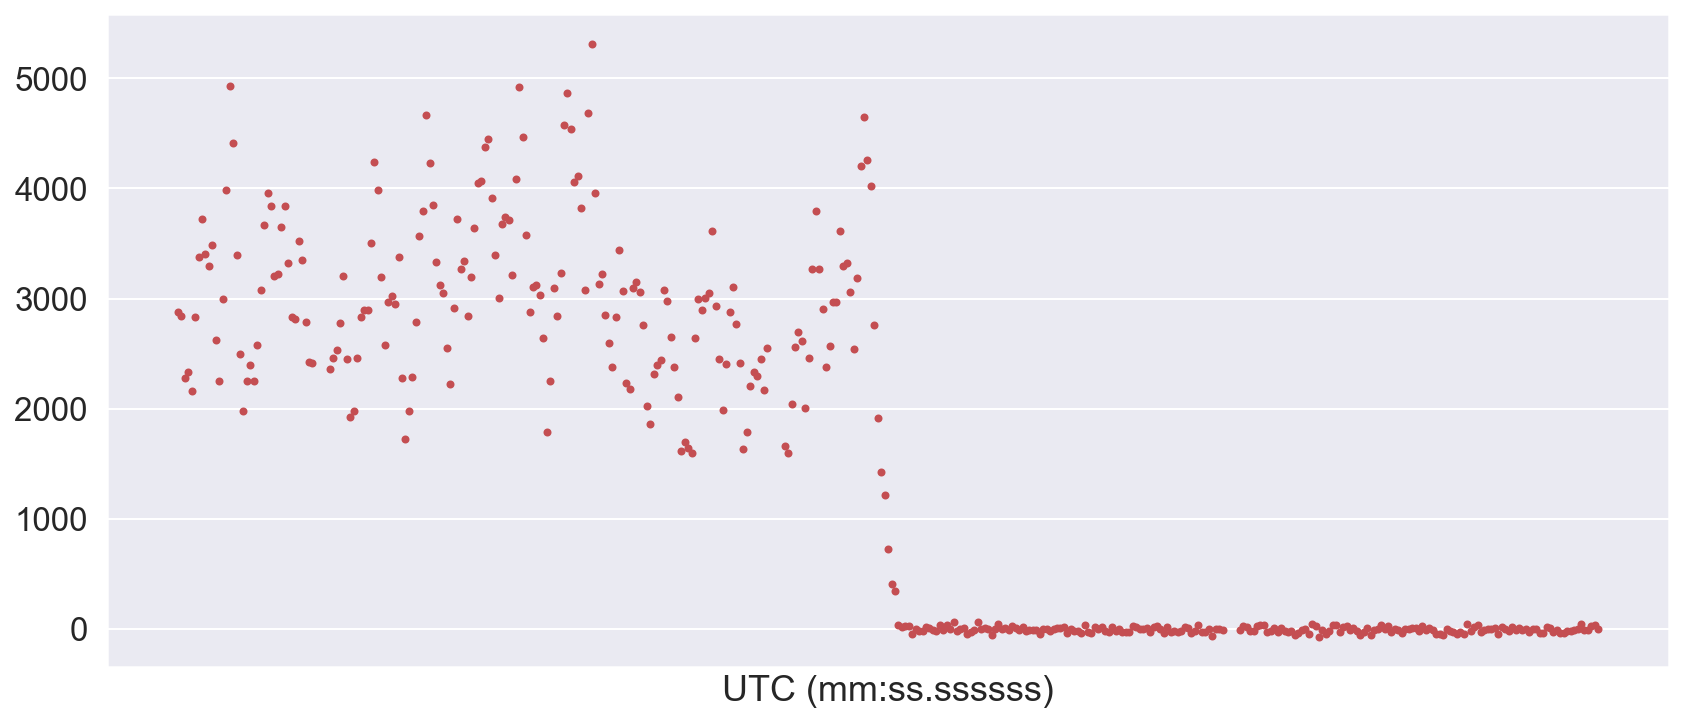

In [51]:
plt.figure(figsize=(14,6))
# plt.plot(data['Time'], data['Value'], 'r-')
plt.scatter(data['Time'], data['Value'], marker='.', c='r')
plt.xlabel('UTC (mm:ss.ssssss)')

### Cek keseragaman *time stamp*

Data yang diambil memiliki *framerate* sebesar 120 fps, artinya setiap frame diambil dengan waktu paparan 1/120 detik atau sekitar 0,008 detik (8 ms). Jika *time stamp*-nya bisa diandalkan, maka seharusnya selisih waktu setiap frame berada di angka $\sim$8 ms

In [52]:
selisih = data['Time'].diff()
# selisih
selisih_drop = selisih.drop([0])
selisih_drop.value_counts()

0 days 00:00:00.008056    244
0 days 00:00:00.008057    149
0 days 00:00:00.040282      3
0 days 00:00:00.008177      3
0 days 00:00:00.008178      1
Name: Time, dtype: int64

<AxesSubplot:>

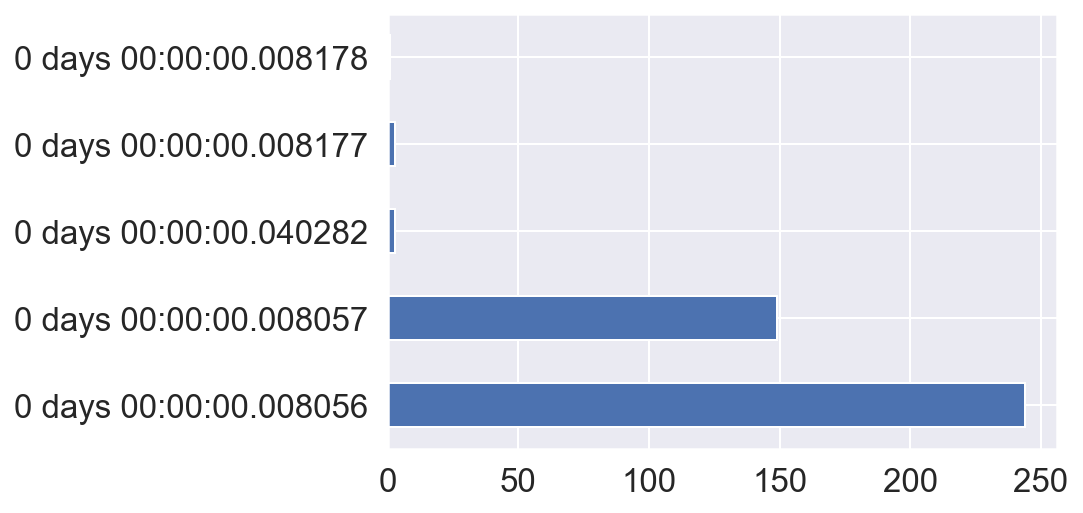

In [53]:
selisih_drop.value_counts().plot(kind='barh')

In [54]:
np.math.factorial(4)

24

In [55]:
x = np.linspace(-1000, 1000, 10000)

In [56]:
def sigma_sum(start, end, expression):
    return sum(expression(i) for i in range(start, end+1)) # end+1 memastikan value dari index terakhir ikut dihitung

In [ ]:
def fungsi_cos(x):
    coef = (-1)**i
    num = x**(2*i+1)
    den = (np.math.factorial(2*i)) * (4*i+1)
    return coef * (num / den)

# sigma_sum(0, 10, fungsi)

In [ ]:
sigma_sum(0, 10, fungsi_cos(x))

In [ ]:
def fresnel_cos(x, n):
    cos_approx = 0
    for i in range(n):
        coef = (-1)**i
        num = x**(2*i+1)
        den = (np.math.factorial(2*i)) * (4*i+1)
        cos_approx += (coef) * ((num) / (den))
    return cos_approx

In [ ]:
def fresnel_sin(x, n):
    sin_approx = 0
    for i in range(n):
        coef = (-1)**i
        num = x**(2*i+3)
        den = (np.math.factorial(2*i+1)) * (4*i+3)
        sin_approx += (coef) * ((num) / (den))
    return sin_approx

In [ ]:
def fresnel_func(x, n, A):
    return A*0.5*((fresnel_cos(x, n) + 0.5)**2 + (fresnel_sin(x, n) + 0.5)**2)

In [ ]:
y = fresnel_func(x, 10, 100)

In [ ]:
plt.plot(x, y)

In [ ]:
xx = np.linspace(-5,5,100)
# n = len(x)

with pm.Model() as test:
    ϵ = pm.HalfCauchy('ϵ', beta=1)
    A = pm.Normal('A', mu=10, sigma=100)
    
    μ = fresnel_func(xx, 100., A)
    
#     pred = pm.Normal('pred', mu=μ, sigma=ϵ, observed=yy)
pm.model_to_graphviz(test)

In [ ]:
xx.dtype

In [ ]:
fresnel_sin(x, len(x))

In [ ]:
fresnel_cos(x, len(x))

In [ ]:
pm.__version__

In [ ]:
import bambi

In [ ]:
xxx = np.linspace(-5, 5, 100)
cc, ss = scipy.special.fresnel(xxx)

In [ ]:
lengthscale = 0.2
eta = 5.0
cov = eta ** 2 * pm.gp.cov.ExpQuad(1, lengthscale)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))

plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, shape=K.shape[0]).random(size=10).T, alpha=0.5)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

In [ ]:
def model_factory(X=np.arange(3), y=None):
    with pm.Model() as model:
        beta_g = pm.Normal("beta_g", mu=0, sigma=1)
        gamma = pm.Gamma("gamma", alpha=10, beta=10)
        z = pm.Normal("z", mu=0, sigma=1, shape=X.shape[1])
        sigma = pm.Gamma("sigma", alpha=3, beta=3)
        beta = beta_g + gamma * z
        y = pm.Normal(
            "y",
            mu=tt.dot(X, beta),
            sigma=sigma,
            shape=X.shape[:-1],
            observed=y
        )
    return model

In [ ]:
# Data generation
X = np.random.randn(400, 3)
X[:, 0] = 1.
with model_factory(X):
    prior = pm.sample_prior_predictive(samples=1)
y = prior.pop("y")
true_parameters = prior
print(true_parameters)

In [ ]:
# Inference
with model_factory(X, y) as model:
    trace = pm.sample(return_inferencedata=True, cores=1)
    pm.plot_posterior(trace)

In [ ]:
import corner

np.random.seed(11234)

x = np.random.randn(2, 2000)
data = az.from_dict(
    posterior={
        "x": x,
        "y": np.random.randn(2, 2000, 2)
    },
    sample_stats={
        "diverging": x < -1.2
    }
)

In [ ]:
figure = corner.corner(data, divergences=True)

In [ ]:
np.arange(3)

In [ ]:
import numpy as np

In [ ]:
a = [1,2,3]
b = [5,6,7,8]

In [ ]:
c = np.convolve(a, b, mode='same')

In [ ]:
c

In [ ]:
from scipy.stats import norm

In [ ]:
y1 = norm(1, 1)

In [ ]:
x1 = np.linspace(-5, 5, 200)
x1.shape

In [ ]:
import statistics

In [ ]:
mean = statistics.mean(x1)
sd = statistics.stdev(x1)

In [ ]:
y1 = norm.pdf(x1, mean, sd)

In [ ]:
y1

In [ ]:
plt.plot(x1, y1)

In [ ]:
x2 = np.linspace(0, 10, 100)

In [ ]:
mean2 = statistics.mean(x2)
sd2 = statistics.stdev(x2)

In [ ]:
y2 = norm.pdf(x2, mean2, sd2)

In [ ]:
y2

In [ ]:
plt.plot(x2, y2)

In [ ]:
y3 = np.convolve(y1, y2, mode='same')

In [ ]:
y3.shape

In [ ]:
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x1, y3)